## Data Preparation

In [1]:
# import modules
import numpy as np
import pandas as pd

import os
import pandas as pd

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

# nltk modules
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import keras
keras.__version__

'2.15.0'

In [3]:
#import modules
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
pip install keras_preprocessing

In [5]:
#import modules
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.layers import Conv1D, MaxPooling1D, Bidirectional, GRU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [6]:
#import modules
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

#**Modelling**

In [7]:
dff_f = pd.read_csv('sentiment_dataset.csv', delimiter=';')

In [8]:
data = dff_f[['tweet','neg','neu','pos','com']] # Combining the data

In [9]:
y = data[['neg','neu','pos','com']] # Extracting the target data

In [10]:
# Applied lemmatization on the tweets to convert the word to its meaningful base form.
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
data['tweet_lemmatized']=data['tweet'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

<ipython-input-10-751c46380a63>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tweet_lemmatized']=data['tweet'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))


# Data Preparation untuk LSTM

In [11]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data['tweet_lemmatized'].values) #Creates the vocabulary index based on word frequency.
X = tokenizer.texts_to_sequences(data['tweet_lemmatized'].values) # Transforms each text in texts to a sequence of integers
X = pad_sequences(X)

In [12]:
#splitting into train, test
X_train, X_v, y_train, y_v = train_test_split(X,y, test_size = 0.4, random_state = 42,shuffle=True)

In [13]:
#splitting into validation and test
X_val,X_test,y_val,y_test = train_test_split(X_v,y_v,test_size=0.2,random_state=42,shuffle=True)

In [14]:
# Input/Hyper parameters
maxlen = X.shape[1]  # Maximum length would length of our sequence for every tweet
max_words = 500  # Maximum number of words
embedding_dim = 120 # Dimension of  embedding layer that is learned

In [15]:
model3 = Sequential() # initialize model

model3.add(Embedding(max_words, embedding_dim, input_length = maxlen)) # Embedding layer definition

# Convolution layers
model3.add(Conv1D(filters=32, kernel_size=2, input_shape=(X.shape[1],embedding_dim)))  # first convolution layer
model3.add(Dropout(0.1))
model3.add(MaxPooling1D(2)) # max pooling

model3.add(Conv1D(filters=64, kernel_size=2)) # second convolution layer
model3.add(Dropout(0.1))
model3.add(MaxPooling1D(2)) # max pooling

# LSTMs
model3.add(Bidirectional(LSTM(180, dropout=0.1,activation='linear',return_sequences=True)))
model3.add(LSTM(50, dropout=0.1,activation='linear',return_sequences=True))

# GRU
model3.add(GRU(20, activation='relu',return_sequences=True))

#RNN
model3.add(SimpleRNN(20, activation='relu'))


# DENSE layer
model3.add(Dense(4,activation='linear'))


model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 120)           60000     
                                                                 
 conv1d (Conv1D)             (None, 42, 32)            7712      
                                                                 
 dropout (Dropout)           (None, 42, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 21, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 64)            4160      
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                        

# Model Training

Epochs: 100

Batch Size: 50

In [18]:
# Compiling the model
model3.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


# Introducing early stopping to reduce overfitting (when loss function has stopped improving)
es = EarlyStopping(monitor='val_loss', mode='min',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)



# model fit and storing all results in the history variable
history = model3.fit(X_train, y_train,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val, y_val),callbacks=[es],shuffle=True)

Epoch 1/100
3/3 [==============================] - 12s 662ms/step - loss: 0.0175 - mae: 0.0706 - val_loss: 0.0043 - val_mae: 0.0302
Epoch 2/100
3/3 [==============================] - 0s 130ms/step - loss: 0.0125 - mae: 0.0606 - val_loss: 0.0075 - val_mae: 0.0473
Epoch 3/100
3/3 [==============================] - 0s 132ms/step - loss: 0.0100 - mae: 0.0536 - val_loss: 0.0146 - val_mae: 0.0699
Epoch 4/100
3/3 [==============================] - 0s 139ms/step - loss: 0.0080 - mae: 0.0442 - val_loss: 0.0040 - val_mae: 0.0261
Epoch 5/100
3/3 [==============================] - 0s 141ms/step - loss: 0.0085 - mae: 0.0506 - val_loss: 0.0039 - val_mae: 0.0266
Epoch 6/100
3/3 [==============================] - 0s 141ms/step - loss: 0.0058 - mae: 0.0341 - val_loss: 0.0095 - val_mae: 0.0542
Epoch 7/100
3/3 [==============================] - 0s 143ms/step - loss: 0.0073 - mae: 0.0422 - val_loss: 0.0060 - val_mae: 0.0412
Epoch 8/100
3/3 [==============================] - 0s 127ms/step - loss: 0.0054 - 

# Loss Function

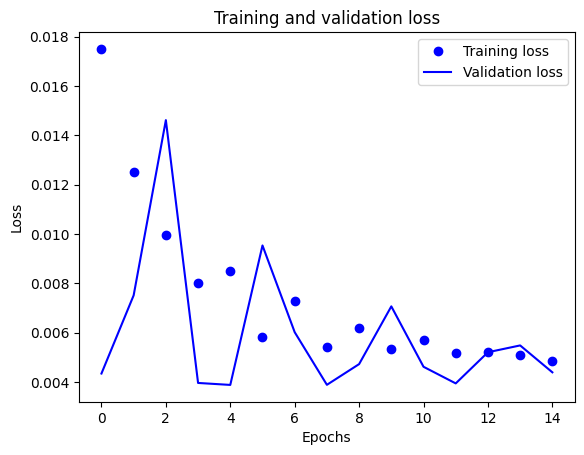

In [19]:
import matplotlib.pyplot as plt

# extracting loss values for train and validation
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting loss values for all epochs
epochs = range(len(loss))


# plots
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

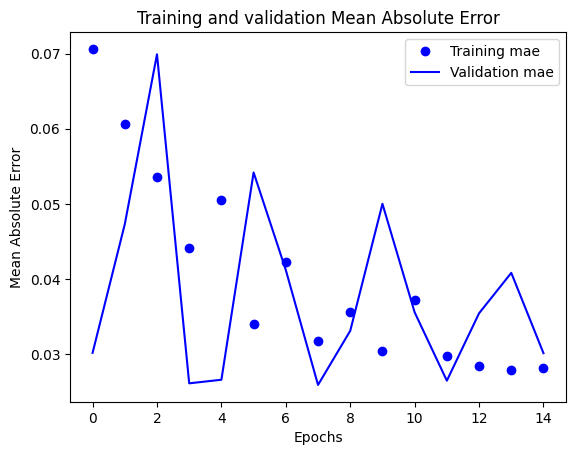

In [20]:
import matplotlib.pyplot as plt


loss = history.history['mae']
val_loss = history.history['val_mae']

epochs = range(len(loss))



plt.plot(epochs, loss, 'bo', label='Training mae')
plt.plot(epochs, val_loss, 'b', label='Validation mae')
plt.title('Training and validation Mean Absolute Error')

plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')

plt.legend()

plt.show()

# Prediksi Komputasi

In [21]:
y_pred_train=model3.predict(X_train)
y_pred_test = model3.predict(X_test)

1/1 [==============================] - 0s 116ms/step


# Analisis Sentimen Metriks

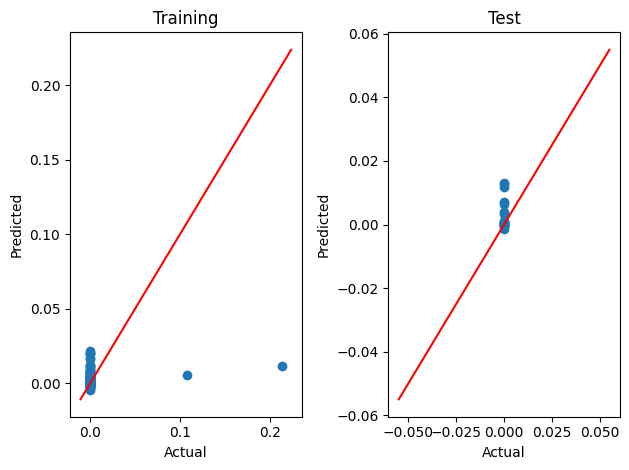

In [22]:
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
i = 0
axes[0].scatter(x=y_train['neg'], y=y_pred_train[:,i]) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test['neg'], y=y_pred_test[:,i]) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [23]:

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
i = 0
print('-----------------------------------------------------------------------------------------')
print('Train: R2 for negative sentiment:',r2_score(y_train['neg'],y_pred_train[:,i]))
print('Train: rmse for negative sentiment:',np.sqrt(mean_squared_error(y_train['neg'],y_pred_train[:,i])))
print('Train: MAE for negative sentiment:',mean_absolute_error(y_train['neg'], y_pred_train[:,i]))
print('-----------------------------------------------------------------------------------------')
print('Test: R2 for negative sentiment:',r2_score(y_test['neg'],y_pred_test[:,i]))
print('Test: rmse for negative sentiment:',np.sqrt(mean_squared_error(y_test['neg'],y_pred_test[:,i])))
print('Test: MAE for negative sentiment:',mean_absolute_error(y_test['neg'], y_pred_test[:,i]))
print('-----------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------
Train: R2 for negative sentiment: 0.027259339031483143
Train: rmse for negative sentiment: 0.02013580882411727
Train: MAE for negative sentiment: 0.005325777549324212
-----------------------------------------------------------------------------------------
Test: R2 for negative sentiment: 0.0
Test: rmse for negative sentiment: 0.005763684227078098
Test: MAE for negative sentiment: 0.0036264353742202124
-----------------------------------------------------------------------------------------


# Evaluasi Netral

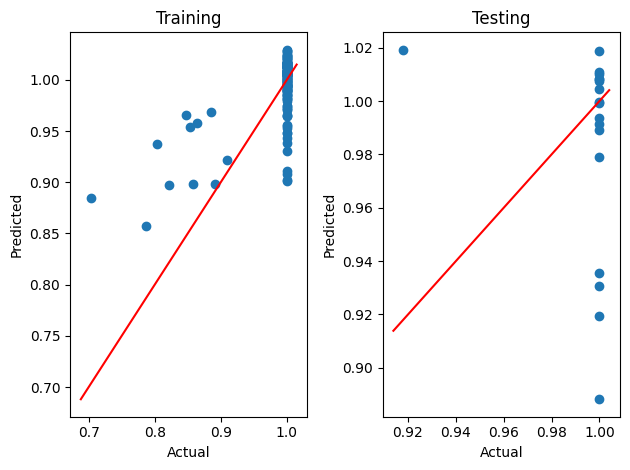

In [24]:
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
i = 1
axes[0].scatter(x=y_train['neu'], y=y_pred_train[:,i]) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test['neu'], y=y_pred_test[:,i]) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Testing")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
i = 1
print('-----------------------------------------------------------------------------------------')
print('Train: R2 for neutral sentiment:',r2_score(y_train['neu'],y_pred_train[:,i]))
print('Train: rmse for neutral sentiment:',np.sqrt(mean_squared_error(y_train['neu'],y_pred_train[:,i])))
print('Train: MAE for neutral sentiment:',mean_absolute_error(y_train['neu'], y_pred_train[:,i]))
print('-----------------------------------------------------------------------------------------')
print('Test: R2 for neutral sentiment:',r2_score(y_test['neu'],y_pred_test[:,i]))
print('Test: rmse for neutral sentiment:',np.sqrt(mean_squared_error(y_test['neu'],y_pred_test[:,i])))
print('Test: MAE for neutral sentiment:',mean_absolute_error(y_test['neu'], y_pred_test[:,i]))
print('-----------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------
Train: R2 for neutral sentiment: 0.37011004000396686
Train: rmse for neutral sentiment: 0.03721843871213022
Train: MAE for neutral sentiment: 0.023009136606145786
-----------------------------------------------------------------------------------------
Test: R2 for neutral sentiment: -5.238751131816235
Test: rmse for neutral sentiment: 0.0469153152353104
Test: MAE for neutral sentiment: 0.030188059515423242
-----------------------------------------------------------------------------------------


# Evaluasi Positif

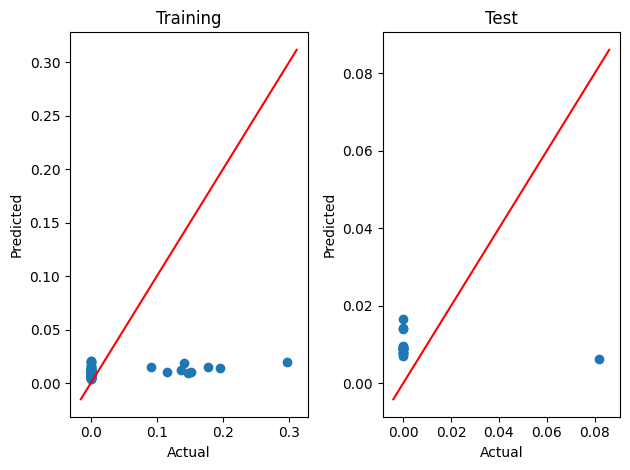

In [26]:
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
i = 2
axes[0].scatter(x=y_train['pos'], y=y_pred_train[:,i]) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test['pos'], y=y_pred_test[:,i]) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
i = 2
print('-----------------------------------------------------------------------------------------')
print('Train: R2 for posititve sentiment:',r2_score(y_train['pos'],y_pred_train[:,i]))
print('Train: rmse for positive sentiment:',np.sqrt(mean_squared_error(y_train['pos'],y_pred_train[:,i])))
print('Train: MAE for positive sentiment:',mean_absolute_error(y_train['pos'], y_pred_train[:,i]))
print('-----------------------------------------------------------------------------------------')
print('Test: R2 for positive sentiment:',r2_score(y_test['pos'],y_pred_test[:,i]))
print('Test: rmse for positive sentiment:',np.sqrt(mean_squared_error(y_test['pos'],y_pred_test[:,i])))
print('Test: MAE for positive sentiment:',mean_absolute_error(y_test['pos'], y_pred_test[:,i]))
print('-----------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------
Train: R2 for posititve sentiment: 0.05746860967269274
Train: rmse for positive sentiment: 0.04157125059617199
Train: MAE for positive sentiment: 0.01824153376188543
-----------------------------------------------------------------------------------------
Test: R2 for positive sentiment: -0.17117571786099384
Test: rmse for positive sentiment: 0.020327166183540066
Test: MAE for positive sentiment: 0.01335697442955441
-----------------------------------------------------------------------------------------


# Evaluasi Gabungan

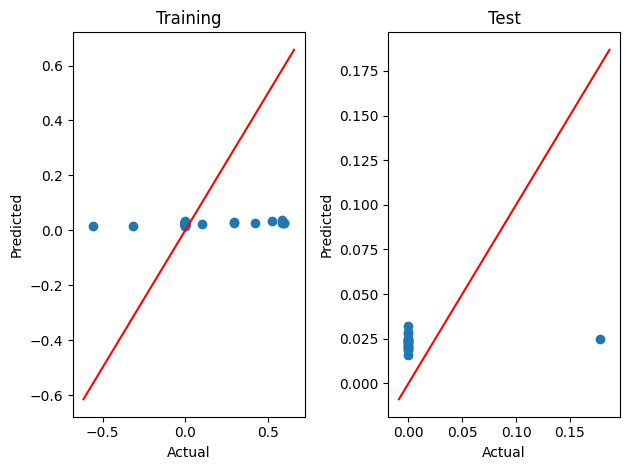

In [28]:
fig, axes = plt.subplots(1,2) # 1 row, 2 columns

# this makes the individual subplots
# Training Results
i = 3
axes[0].scatter(x=y_train['com'], y=y_pred_train[:,i]) #first row, first entry (left top)
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test['com'], y=y_pred_test[:,i]) # first row, second entry (right top)
axes[1].set_xlabel("Actual", fontsize=10)
axes[1].set_ylabel("Predicted",  fontsize=10)
axes[1].set_title("Test")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

# tight layout
fig.tight_layout()

# show the plot
plt.show()

In [29]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
i = 3
print('-----------------------------------------------------------------------------------------')
print('Train: R2 for compound sentiment:',r2_score(y_train['com'],y_pred_train[:,i]))
print('Train: rmse for compound sentiment:',np.sqrt(mean_squared_error(y_train['com'],y_pred_train[:,i])))
print('Train: MAE for compound sentiment:',mean_absolute_error(y_train['com'], y_pred_train[:,i]))
print('-----------------------------------------------------------------------------------------')
print('Test: R2 for compound sentiment:',r2_score(y_test['com'],y_pred_test[:,i]))
print('Test: rmse for compound sentiment:',np.sqrt(mean_squared_error(y_test['com'],y_pred_test[:,i])))
print('Test: MAE for compound sentiment:',mean_absolute_error(y_test['com'], y_pred_test[:,i]))
print('-----------------------------------------------------------------------------------------')

-----------------------------------------------------------------------------------------
Train: R2 for compound sentiment: 0.02399584774798391
Train: rmse for compound sentiment: 0.13131112837510572
Train: MAE for compound sentiment: 0.056030398012024384
-----------------------------------------------------------------------------------------
Test: R2 for compound sentiment: -0.0963658103545395
Test: rmse for compound sentiment: 0.04266833002737895
Test: MAE for compound sentiment: 0.03035174550745222
-----------------------------------------------------------------------------------------
